In [1]:
# matplotlib inline plotting
%matplotlib inline
# make inline plotting higher resolution
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import statsmodels.api as sm

# Styling
plt.style.use('ggplot')

### Purpose
The purpose of this problem is to analyze the predictive ability of the Cyclically Adjusted
Price-Earnings (CAPE) ratio for future stock returns. The CAPE ratio is also known as the
price-smoothed-earnings ratio or as the Shiller $\mathrm{P} / \mathrm{E}$ ratio and the variable is available for free
download at Robert Shiller's website. The CAPE ratio is defined as the real stock price divided
by average real earnings over a ten-year period. It has been used in a series of articles by John
Campbell and Robert Shiller to examine long-horizon stock market predictability.

From our data-source we know that,
* ret: the return on the US stock market including all firms on the NYSE, AMEX, and NASDAQ 
* rf: proxy for the risk-free rate
* cape: cyclically adjusted price-earnings ratio

_I unfortunetly can't upload the data-file for this particular project._

In [2]:
# load and parse data
df = pd.read_excel('data/CAPE and US-market returns.xlsx', index_col=0, usecols='A:D')

df['parse_date'] = df.index
df['parse_date'] = df['parse_date'].apply(lambda x: datetime.strptime(str(x), '%Y%m'))

df = df.set_index('parse_date')
df.index.name = None

df.head()

,ret,rf,cape
1926-07-01,0.0318,0.0022,11.869694
1926-08-01,0.0289,0.0025,12.488808
1926-09-01,0.0059,0.0023,12.692615
1926-10-01,-0.0292,0.0032,12.426518
1926-11-01,0.0284,0.0031,12.615251


### Problem 1
Estimate long-horizon predictive regressions:
    
\begin{align*}
    r_{t \rightarrow t+k}=\alpha_{k}+\beta_{k} x_{t}+\varepsilon_{t \rightarrow t+k}\tag{1}
\end{align*}

where $r_{t \rightarrow t+k}$ is the log excess return on the US stock market from time $t$ to $t+k$ and $x_{t}$ is the log CAPE ratio at time $t$. Consider horizons in the range from one month up to ten years: $k=1,6,12,24,36,48,60,72,84,96,108,$ and $120 .$ Report and compare the $\beta_{k}$ coefficients and $R^{2}$ statistics across the forecast horizons. The sample period is from **1926:m7** to **2020:m7**

In [3]:
# settings
windows = [1, 6, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]
n_lags = 1

Lets first check if we have selected the right data...

In [4]:
print(f'First observation: {df.iloc[0].name}')
print(f'Last observation: {df.iloc[-1].name}')

First observation: 1926-07-01 00:00:00
Last observation: 2020-07-01 00:00:00


Now let's start out by creating log excess return $t\rightarrow t+k$ and $x_t$ as the log CAPE ratio at time $t$

In [5]:
# t net returns/rate
df['ret'] = df['ret'] + 1
df['rf'] = df['rf'] + 1

# log t CAPE
df['lcape'] = np.log(df['cape'])
df.head()

,ret,rf,cape,lcape
1926-07-01,1.0318,1.0022,11.869694,2.473988
1926-08-01,1.0289,1.0025,12.488808,2.524833
1926-09-01,1.0059,1.0023,12.692615,2.541020
1926-10-01,0.9708,1.0032,12.426518,2.519833
1926-11-01,1.0284,1.0031,12.615251,2.534906


To calculate $t\rightarrow t+k$ period log excess return we need to write a small function, which loops the series for both risk-free rate and stock-returns taking the product for each k-period window. 

We then log these values and take the difference with the risk-free rate to have our $t\rightarrow t+k$ period changes.

In [6]:
def rolling_backwards_product(s, k):
    # reverse series to make t->(t+k) change
    s = s.sort_index(ascending=False)
    # make rolling series
    s = s.rolling(k)
    
    return s.apply(np.prod, raw=True)


for window in windows:
    df[f'{window}_leret'] = np.log(rolling_backwards_product(df['ret'], window)) - np.log(rolling_backwards_product(df['rf'], window))


display(df.head())

,ret,rf,cape,lcape,1_leret,6_leret,12_leret,24_leret,36_leret,48_leret,60_leret,72_leret,84_leret,96_leret,108_leret,120_leret
1926-07-01,1.0318,1.0022,11.869694,2.473988,0.029107,0.076557,0.151879,0.395039,0.695591,0.348264,0.031850,-1.055330,-0.112727,-0.160007,-0.070980,0.304169
1926-08-01,1.0289,1.0025,12.488808,2.524833,0.025993,0.046851,0.192655,0.372093,0.709978,0.359452,-0.065708,-0.793039,-0.243071,-0.305186,-0.027681,0.339625
1926-09-01,1.0059,1.0023,12.692615,2.541020,0.003585,0.061703,0.186116,0.410563,0.762309,0.336451,-0.087611,-0.503864,-0.155322,-0.276886,-0.027522,0.323481
1926-10-01,0.9708,1.0032,12.426518,2.519833,-0.032830,0.059413,0.228937,0.435296,0.702673,0.196794,-0.435396,-0.537282,-0.271492,-0.282774,-0.005150,0.329647
1926-11-01,1.0284,1.0031,12.615251,2.534906,0.024909,0.096821,0.217823,0.481284,0.512011,0.137814,-0.325310,-0.645640,-0.325956,-0.266682,0.095612,0.431243


Now we can simply estimate the long-run predictive regression from $(1)$ and report our estimates - we'll use the statsmodels package here.

In [11]:
def slice_dataframe(k):
    # slice dataframe for relevant information
    reg = df[[f'{k}_leret','lcape']].copy()

    # when using predictive regressions we lag our return vector
    reg['lcape'] = reg['lcape'].shift(n_lags)

    # drop all nan's
    reg.dropna(inplace=True)
    
    return (reg['lcape'], reg[f'{k}_leret'])


# fit model using statsmodels - should be self explainatory
def fit_model(k):
    X, y = slice_dataframe(k)
    X = sm.add_constant(X)

    res = sm.OLS(y, X).fit()
    
    return {'k': window,
            't-stat': res.tvalues[1],
            'beta_k': res.params[1],
            'R squared': res.rsquared}


# save and make output pretty
results = pd.DataFrame()

for window in windows:
    results = results.append(fit_model(window), ignore_index=True)

results.set_index('k')

,R squared,beta_k,t-stat
k,,,
1.0,0.005432,-0.009782,-2.479791
6.0,0.032798,-0.061759,-6.165499
12.0,0.072695,-0.136438,-9.349302
24.0,0.133141,-0.263625,-13.015738
36.0,0.169402,-0.353641,-14.916797
48.0,0.189981,-0.419058,-15.908085
60.0,0.198330,-0.460648,-16.247180
72.0,0.209949,-0.475547,-16.743863
84.0,0.239954,-0.516682,-18.146232


### Solution
We see that $R^2$ increase with $k$ - thus the predictive power of CAPE increase with the time-horizon. We expect that the price-earnings ratio is highly persistent and slow to mean-revert due to high $\phi$ in our MA-process for the error-term $\varepsilon_{t \rightarrow t+k} \sim M A(k-1)$. 

Intuitively this means that when prices are high relative to earnings, we'd expect lower stock returns.

### Problem 2

The use of overlapping data in (1) leads to autocorrelation in the error term. To address this issue, we can use e.g. the Newey-West estimator to compute $t$ -statistics across the different forecast horizons. To examine the effect of how standard errors are computed in long-horizon regressions, try with two different lag-length specifications in the Newey-West estimator. First, try to set the lag length in the Newey-West estimator equal to the forecast horizon and then afterwards try with no lags in the Newey-West estimator.

We can reuse some of the code from **Problem 1**, however we only need to adjust our covariance-matrix calculation such that it calculates heteroscedasticity and autocorrelation robust std. errors.

In [8]:
# fit model using statsmodels - should be self explainatory
def fit_model_neweywest(k):
    X, y = slice_dataframe(k)
    X = sm.add_constant(X)

    NW_k_lags = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': k})
    NW_0_lags = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 0})
    
    return {'k': window,
            'beta_k': NW_k_lags.params[1],
            'R squared': NW_k_lags.rsquared,
            't-stat (k lags)': NW_k_lags.tvalues[1],
            't-stat (0 lags)': NW_0_lags.tvalues[1]}


# save and make output pretty
results = pd.DataFrame()

for window in windows:
    results = results.append(fit_model_neweywest(window), ignore_index=True)

# print results
results.set_index('k')

,R squared,beta_k,t-stat (0 lags),t-stat (k lags)
k,,,,
1.0,0.005432,-0.009782,-2.028352,-1.831084
6.0,0.032798,-0.061759,-5.952230,-3.040038
12.0,0.072695,-0.136438,-9.257427,-3.423782
24.0,0.133141,-0.263625,-12.989475,-3.283021
36.0,0.169402,-0.353641,-13.784869,-3.066353
48.0,0.189981,-0.419058,-16.111079,-3.209365
60.0,0.198330,-0.460648,-18.894856,-3.537802
72.0,0.209949,-0.475547,-20.524614,-3.580867
84.0,0.239954,-0.516682,-22.790482,-3.486762


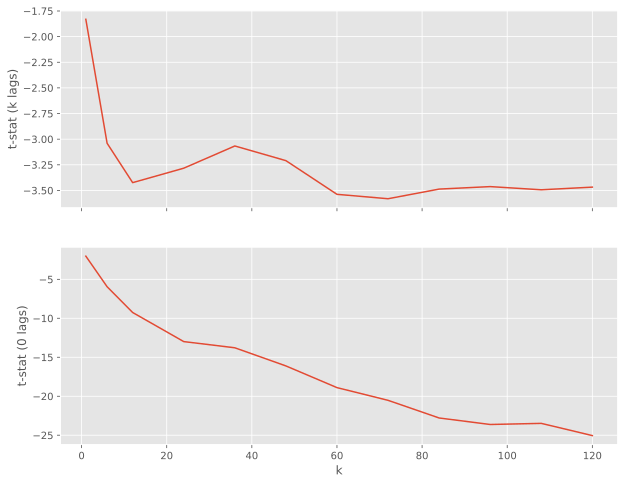

In [9]:
figure, axes = plt.subplots(2, 1, figsize=(10,8), sharex=True)

sns.lineplot(x=results['k'], y=results['t-stat (k lags)'], ax=axes[0])
sns.lineplot(x=results['k'], y=results['t-stat (0 lags)'], ax=axes[1])

plt.show()

### Solution

* We clearly see that autocorrelation was an issue in the first predictive regression using normal OLS std. errors - these are flawed and thus cannot be used for inference.
* All t-statistics are however in the rejection region $(\alpha=0.05)$ of the $H_0:\; \beta_k=0$ _(Newey West std. errors)_
* The reason why $k$ lags is a relevant choice is that the overlap in returns implies that $\varepsilon_{t+k} \sim M A(k-1)$ by construction.
* We have again here that the predictive power of CAPE increases with longer horizons, however more slightly when adjudsting (using Newey West std. errors).

### Problem 3

Similar to the price-dividend ratio, the CAPE ratio is highly persistent and slow to mean-revert, implying that forecasts build up over time. Make two scatter plots where you plot the time $t$ log CAPE ratio against the one-month ahead log excess return $\left(r_{t \rightarrow t+1}\right)$ and the ten-year ahead log excess return $\left(r_{t \rightarrow t+120}\right),$ respectively.

Here we simply use the `slice_dataframe(k)` function and plot the resulting two timeseries using regplot from Seaborn. Regplot is basically just a prettified scatterplot with a linear-fit line included.

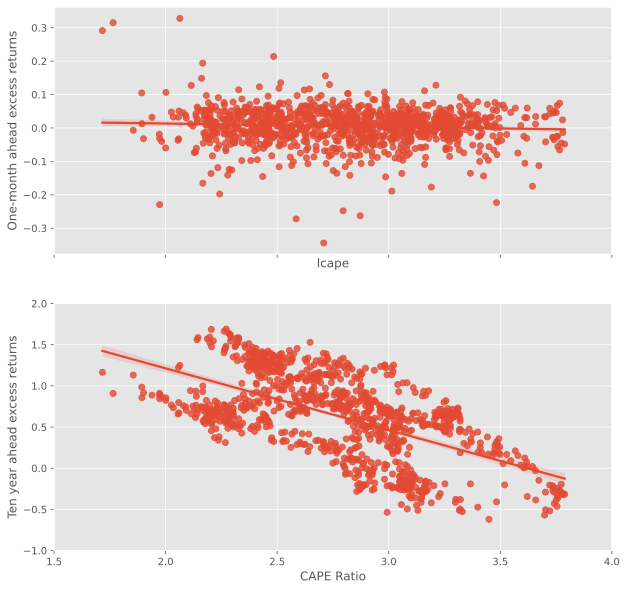

In [10]:
(lcape_1, lr_1) = slice_dataframe(1)
(lcape_120, lr_120) = slice_dataframe(120)

figure, axes = plt.subplots(2, 1, figsize=(10,10), sharex=True)

sns.regplot(x=lcape_1, y=lr_1, ax=axes[0])

axes[0].set_ylabel('One-month ahead excess returns')
plt.xlim(1.5, 4)
plt.ylim(-0.4, 0.4)


sns.regplot(x=lcape_120, y=lr_120, ax=axes[1])

axes[1].set_ylabel('Ten year ahead excess returns')
plt.xlim(1.5, 4)
plt.ylim(-1, 2)

plt.xlabel('CAPE Ratio')

plt.show()

### Solution

As assumed _(also from the conclusions to problem 1 and 2)_ the predictive power of CAPE is a lot more visible when looking at longer horizons - it is slower to mean revert at longer horizons.